In [1]:
import scanpy as sc
import scFates as scf

import warnings
warnings.filterwarnings("ignore")
import pandas as pd

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [2]:
import cudf
cnts=cudf.read_csv("GSE134912_spongilla_10x_count_matrix.txt",sep="\t",index_col=0)

In [3]:
adata=sc.AnnData(cnts.to_pandas().T)

In [4]:
import scipy.sparse as sp

In [5]:
adata.X=sp.csr_matrix(adata.X)

In [6]:
sc.pp.calculate_qc_metrics(adata,inplace=True,log1p=False,percent_top=None)

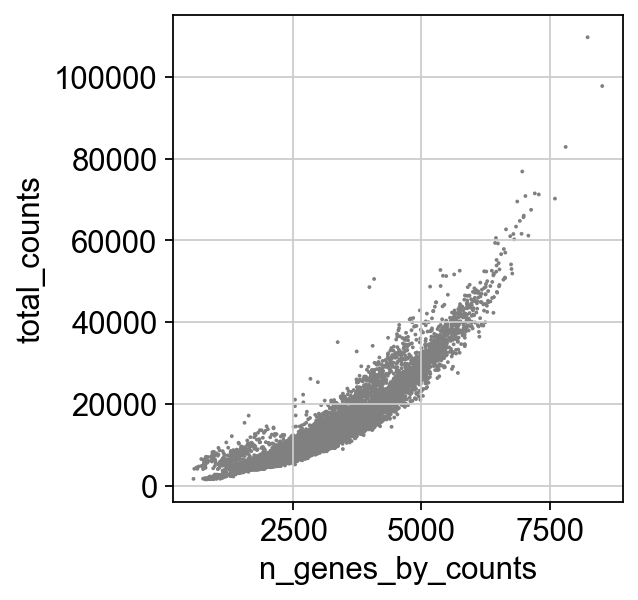

In [7]:
sc.set_figure_params()
sc.pl.scatter(adata,x='n_genes_by_counts',y='total_counts')

In [8]:
adata.raw=adata

In [9]:
sc.pp.filter_genes(adata,min_cells=3)

In [10]:
sc.pp.normalize_total(adata,target_sum=1e3)
sc.pp.log1p(adata)

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 2430 over-dispersed features (0:00:02) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



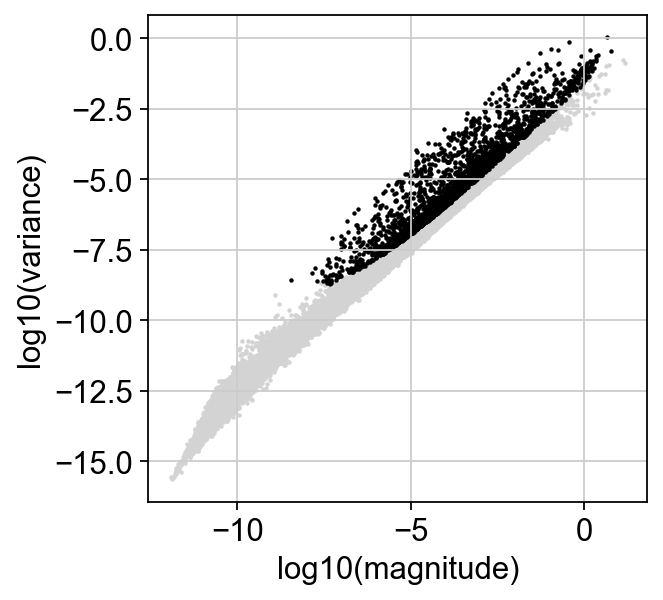

In [11]:
scf.pp.find_overdispersed(adata,plot=True)

In [12]:
adata=adata[:,adata.var.highly_variable]

In [13]:
sc.pp.scale(adata,max_value=10)
sc.pp.pca(adata)

In [14]:
sc.pp.neighbors(adata,n_neighbors=30)

In [15]:
sc.tl.umap(adata,method="rapids")

In [16]:
sc.tl.leiden(adata,resolution=.5,flavor="rapids")

In [17]:
cluster=pd.read_csv("clusters_42_34_and_oddcells_reassigned.txt",sep=" ",index_col=0,header=None)

In [18]:
adata.obs["clusters"]=cluster.loc[adata.obs_names].values.ravel().astype(str)


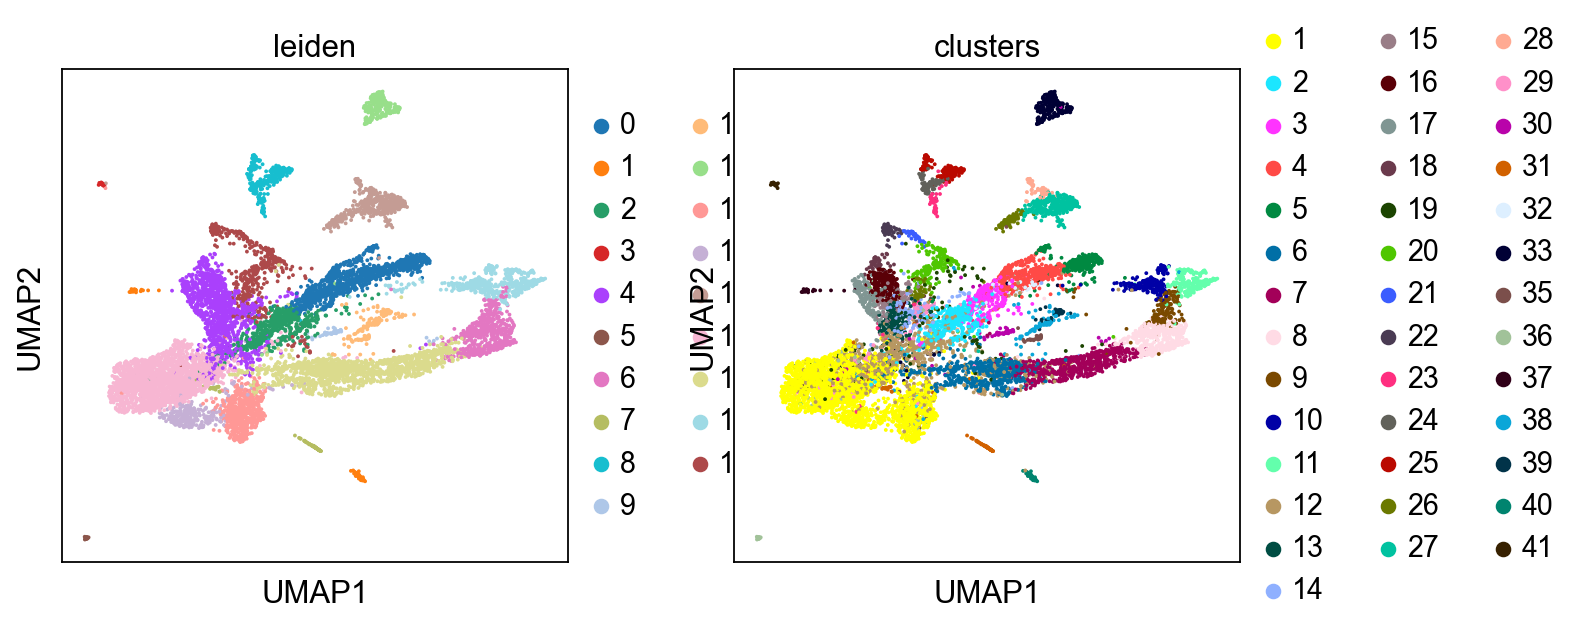

In [22]:
sc.pl.umap(adata,color=["leiden","clusters"])

In [24]:
sc.tl.draw_graph(adata,init_pos='X_umap',method="rapids")

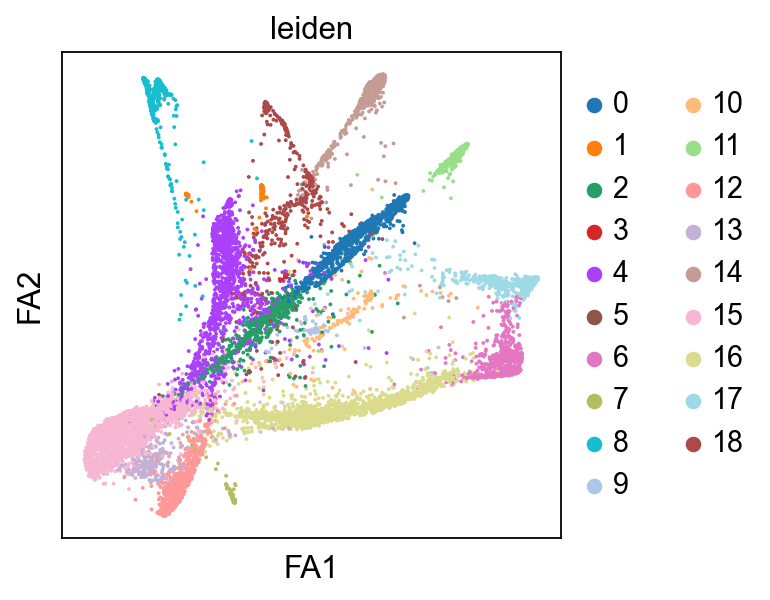

In [25]:
sc.pl.draw_graph(adata,color="leiden")

In [19]:
from cellrank.tl.kernels import CytoTRACEKernel
import scvelo as scv
def get_cytotrace(adata):
    sc.pp.filter_genes(adata, min_cells=10)
    scv.pp.normalize_per_cell(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)

    adata.layers["spliced"] = adata.X
    adata.layers["unspliced"] = adata.X
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    ctk = CytoTRACEKernel(adata)

In [21]:
adata_raw=adata.raw.to_adata()

In [22]:
get_cytotrace(adata_raw)

Normalized count data: X.
computing moments based on connectivities
    finished (0:00:15) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


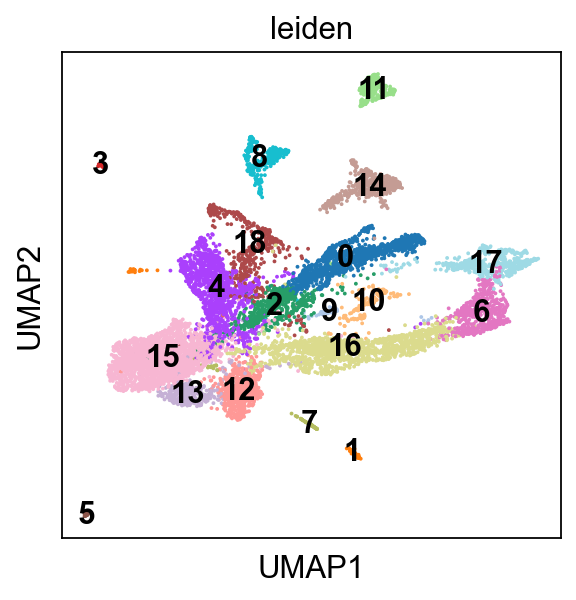

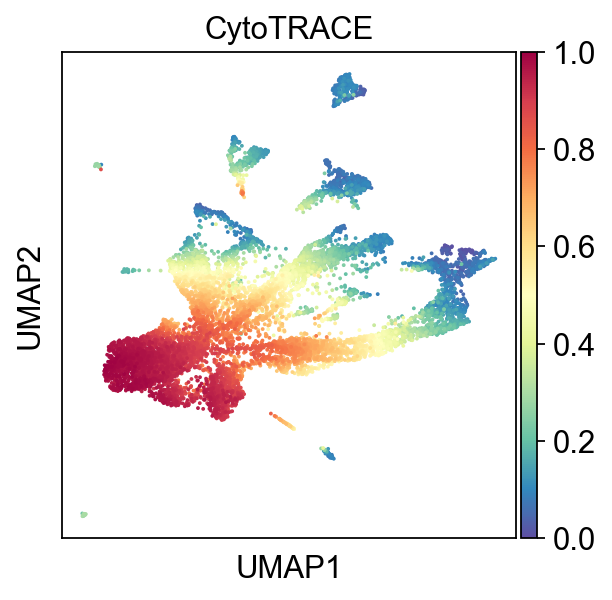

In [23]:
adata.obs["CytoTRACE"]=adata_raw.obs.ct_score
sc.pl.umap(adata,color="leiden",legend_loc='on data')
sc.pl.umap(adata,color="CytoTRACE",cmap="Spectral_r")

In [24]:
adata.raw.var_names.name=None

In [25]:
adata.var_names.name=None

In [26]:
adata.write("adata_processed.h5ad")